In [ ]:
#Install Kaggle dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lukechugh/best-alzheimer-mri-dataset-99-accuracy")

print("Path to dataset files:", path)

100%|██████████| 71.5M/71.5M [00:00<00:00, 111MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy/versions/1


In [ ]:
!pip install torch

In [ ]:
! cd /root/.cache/kagglehub/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy/versions/1
! ls

sample_data


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
BATCH_SIZE = 32

# EXAMPLE TRANSFORMATION - This example is for a dataset which involves colored images
# this is a commonly used transformation for models involving ImageNet dataset, but is not useful for our MNIST Dataset
example_transform = transforms.Compose([
    transforms.Resize(256), #resizes smaller side of image to 256, maintains aspect ratio
    transforms.CenterCrop(256), #crops or pads image to be 256x256
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), #Normalizing the RGB values
    transforms.ToTensor()])


# Since our data is very simple, all we really need to do is convert to a tensor, although you can also experiment
# With resizing and other transformations to see if your results improve
transform = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:

train_path = path + "/Combined Dataset/train"
test_path = path + "/Combined Dataset/test"
# Load training set from image directory
trainset = torchvision.datasets.ImageFolder(train_path,
                                            transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

# Load testing set from image directory
testset = torchvision.datasets.ImageFolder(test_path,
                                           transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

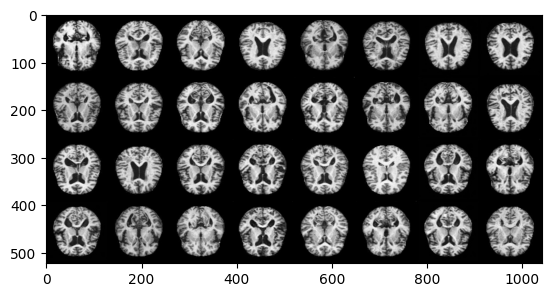

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

## functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

## show images
imshow(torchvision.utils.make_grid(images))

In [ ]:
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([32, 3, 128, 128])
Image label dimensions: torch.Size([32])


In [ ]:
class MRICNNModel(nn.Module):

  def __init__(self):
    super(MRICNNModel, self).__init__()
    # TODO: Add layers here
    self.layer1 = nn.Conv2d(3, 16, 3, padding=1)
    self.layer2 = nn.Conv2d(16, 32, 3, padding=1)
    self.layer3 = nn.Conv2d(32, 64, 3, padding=1)
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(2, 2)
    self.linear = nn.Linear(64*16*16, 10)
    self.final_classifier = nn.Linear(10, 4)

  def forward(self, x):

    # TODO: Pass input through layers
    x = self.relu(self.layer1(x))
    x = self.pool(x)
    x = self.relu(self.layer2(x))
    x = self.pool(x)
    x = self.relu(self.layer3(x))
    x = self.pool(x)
    x = torch.flatten(x, 1)
    x = self.relu(self.linear(x))
    x = self.final_classifier(x)
    return x

In [ ]:
model = MRICNNModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device) #move model to GPU
print(device) #if you're not on GPU make sure to switch runtime to GPU (COLAB)

cuda


In [ ]:
for epoch in range(10):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    num_correct = 0

    ## training step
    for i, (images, labels) in enumerate(trainloader):

        # TODO: move images and labels to device
        images = images.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        ## TODO: forwardprop + backprop + loss
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()

        # Calculate running number of correct predictions
        _, predicted_class = torch.max(output, 1)
        num_correct += (predicted_class == labels).sum().item()

        ## update model params (step optimizer)
        optimizer.step()

        # Calculate running loss
        train_running_loss += loss.detach().item()

    total_images = len(trainloader)*BATCH_SIZE
    train_acc = num_correct/total_images
    train_running_loss /= len(trainloader)
    print(f"Epoch: {epoch}, Loss: {train_running_loss}, Accuracy: {train_acc}")

Epoch: 0, Loss: 1.0067629177123307, Accuracy: 0.48369140625
Epoch: 1, Loss: 0.6699855818413198, Accuracy: 0.71103515625
Epoch: 2, Loss: 0.5557097861543298, Accuracy: 0.7708984375
Epoch: 3, Loss: 0.45248976168222727, Accuracy: 0.825
Epoch: 4, Loss: 0.3755376181099564, Accuracy: 0.8568359375
Epoch: 5, Loss: 0.30616343999281526, Accuracy: 0.8869140625
Epoch: 6, Loss: 0.2576503510819748, Accuracy: 0.9099609375
Epoch: 7, Loss: 0.20595036672893913, Accuracy: 0.9318359375
Epoch: 8, Loss: 0.16716889675008134, Accuracy: 0.9439453125
Epoch: 9, Loss: 0.1183491373725701, Accuracy: 0.96259765625


In [ ]:
# TODO: Set the model to eval mode

predicted_labels = []
actual_labels = []
# Iterate over the data in the test_loader
for i, data in enumerate(testloader):
    # Get the image and label from data
    images, labels = data

    #move images and labels to device
    images = images.to(device)

    # TODO: Make a forward pass in the net with your image
    output = model(images)

    # Get predictions from softmax results of the CNN
    _, predicted = torch.max(output.data, 1)

    #TODO: Iterate through predicted and actual labels and count how many are correct
    predicted = predicted.cpu()
    predicted_labels.extend(predicted.numpy())
    actual_labels.extend(labels.numpy())


In [ ]:
print("Accuracy:", accuracy_score(actual_labels, predicted_labels))
print("Precision:", precision_score(actual_labels, predicted_labels, average='macro'))
print("Recall:", recall_score(actual_labels, predicted_labels, average='macro'))
print("F1 Score:", f1_score(actual_labels, predicted_labels, average='macro'))

Accuracy: 0.9038311180609852
Precision: 0.9329270162342465
Recall: 0.9288379763567438
F1 Score: 0.9292119513562614
